### Goal
This code example shows you how to track multiple losses during training. Why track multiple losses? Because:
- 1. It can help you debug your model during training. For example, your model's performance might still be bad even with a regularization term, and tracking this loss can help you identify if the regularization term is being reduced during training. 
- 2. It can help you identify hyperparameters. For example, imagine you have multiple loss functions being optimized at the same time with each weighted by a different hyperparameter. Without tracking the different losses it would be hard to know which loss function is having the largest effect. Therefore, keeping track of the different losses can help you identify how to weight your different loss functions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import devtorch
%load_ext autoreload
%autoreload 2

In [2]:
class ANNClassifier(devtorch.DevModel):
    
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.layer1 = nn.Linear(n_in, n_hidden, bias=False)
        self.layer2 = nn.Linear(n_hidden, n_out, bias=False)
        self.init_weight(self.layer1.weight, "glorot_uniform")
        self.init_weight(self.layer2.weight, "glorot_uniform")
    
    def forward(self, x):
        x = F.leaky_relu(self.layer1(x.flatten(1, 3)))
        return F.leaky_relu(self.layer2(x))
    
    def get_params_to_regularize(self):    
        return [self.layer1.weight, self.layer2.weight]

In [3]:
class TrackLossTrainer(devtorch.Trainer):
    
    def __init__(self, model, train_dataset, lam, n_epochs=100, batch_size=128, lr=0.001, device="cuda"):
        super().__init__(model=model, train_dataset=train_dataset, n_epochs=n_epochs, batch_size=batch_size, lr=lr, device=device)
        self._lam = lam
        self._epoch_reg_loss = 0  # We create a variable to keep track of the regulirization loss over an epoch
        self.log = {**self.log, "reg_loss": []}  # We extend the log of the devtorch trainer
        
    def loss(self, output, target, model):
        classification_loss = F.cross_entropy(output, target.long())
        regulirization_loss = 0
        for param in model.get_params_to_regularize():
            regulirization_loss = regulirization_loss + self._lam * torch.norm(param, p=1)
        
        # Add the batch regulirization loss to the running epoch regulirization loss
        with torch.no_grad():
            self._epoch_reg_loss += regulirization_loss.item()
        
        return classification_loss + regulirization_loss
    
    # Here we overwrite the on_epoch_complete hook
    def on_epoch_complete(self, save):
        train_loss = self.log["train_loss"][-1]
        self.log["reg_loss"].append(self._epoch_reg_loss)
        print(f"Epoch train_loss={train_loss:.4f} (reg_loss={self._epoch_reg_loss:.4f})")
        self._epoch_reg_loss = 0  # Reset as the epoch as completed

In [4]:
model = ANNClassifier(784, 2000, 10)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST("../../data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("../../data", train=False, download=True, transform=transform)

trainer = TrackLossTrainer(model, train_dataset, lam=10**-5, n_epochs=10, batch_size=128, lr=0.01, device="cuda")
trainer.train(save=False)

INFO:trainer:Completed epoch 0 with loss 619.303636431694 in 7.7065s
Epoch train_loss=619.3036 (reg_loss=241.6004)
INFO:trainer:Completed epoch 1 with loss 266.3173033297062 in 7.6072s
Epoch train_loss=266.3173 (reg_loss=149.4087)
INFO:trainer:Completed epoch 2 with loss 193.89451858401299 in 7.6126s
Epoch train_loss=193.8945 (reg_loss=112.4443)
INFO:trainer:Completed epoch 3 with loss 182.334646910429 in 7.6244s
Epoch train_loss=182.3346 (reg_loss=111.8160)
INFO:trainer:Completed epoch 4 with loss 153.3352319598198 in 7.6106s
Epoch train_loss=153.3352 (reg_loss=97.9464)
INFO:trainer:Completed epoch 5 with loss 152.12149181962013 in 7.6101s
Epoch train_loss=152.1215 (reg_loss=96.6224)
INFO:trainer:Completed epoch 6 with loss 132.4937990307808 in 7.5756s
Epoch train_loss=132.4938 (reg_loss=88.1579)
INFO:trainer:Completed epoch 7 with loss 107.05138802528381 in 7.5770s
Epoch train_loss=107.0514 (reg_loss=68.9373)
INFO:trainer:Completed epoch 8 with loss 112.86570817232132 in 7.5769s
Epoc

Text(0, 0.5, 'Loss')

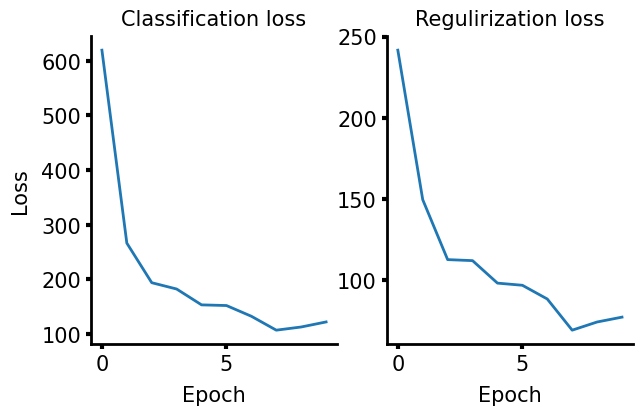

In [5]:
def plot(s, title, ax):
    ax.plot(s, linewidth=2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    fs = 15
    ax.tick_params(axis="both", which="major", labelsize=fs)
    ax.set_title(title, fontsize=fs, pad=8)
    ax.set_xlabel("Epoch", fontsize=fs, labelpad=8)
    
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
plot(trainer.log["train_loss"], "Classification loss", ax[0])
plot(trainer.log["reg_loss"], "Regulirization loss", ax[1])
ax[0].set_ylabel("Loss", fontsize=15, labelpad=8)

**Exercise**: As a fun exercise you could try keep track of the different regulirization losses of each ANN layer. Or perhaps keep track of the test dataset accuracy over the training epochs.